In [1]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt

print(os.getcwd())
img_dir = os.path.join(os.getcwd(), "PGPShelf")
print(img_dir)
%matplotlib inline

/home/minh/workspace/git/hbrs_courses/16s_rp
/home/minh/workspace/git/hbrs_courses/16s_rp/PGPShelf


In [2]:
def compute_sift(image, hessian_threshold):
    sift = cv2.xfeatures2d.SIFT_create(hessian_threshold)
    kp, des = sift.detectAndCompute(image,None)
    img2 = cv2.drawKeypoints(image,kp,None,(0,255,0),4)
    #cv2.startWindowThread()
    #cv2.namedWindow(image_name+"-SURF")
    #cv2.imshow(image_name+"-SURF",img2)
    plt.figure(figsize=(15,15))
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    plt.imshow(img2, cmap="gray")
    return kp,des,img2

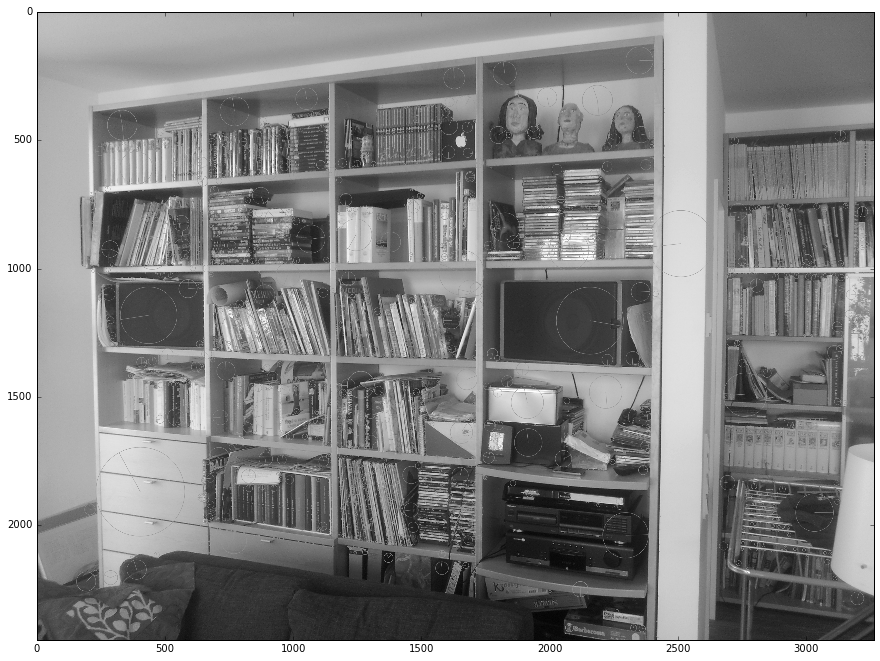

In [3]:
img1 = cv2.imread(os.path.join(img_dir, '20150616_074444.jpg'))
kp_img1, des_img1, img1_gray = compute_sift(img1, 10000)

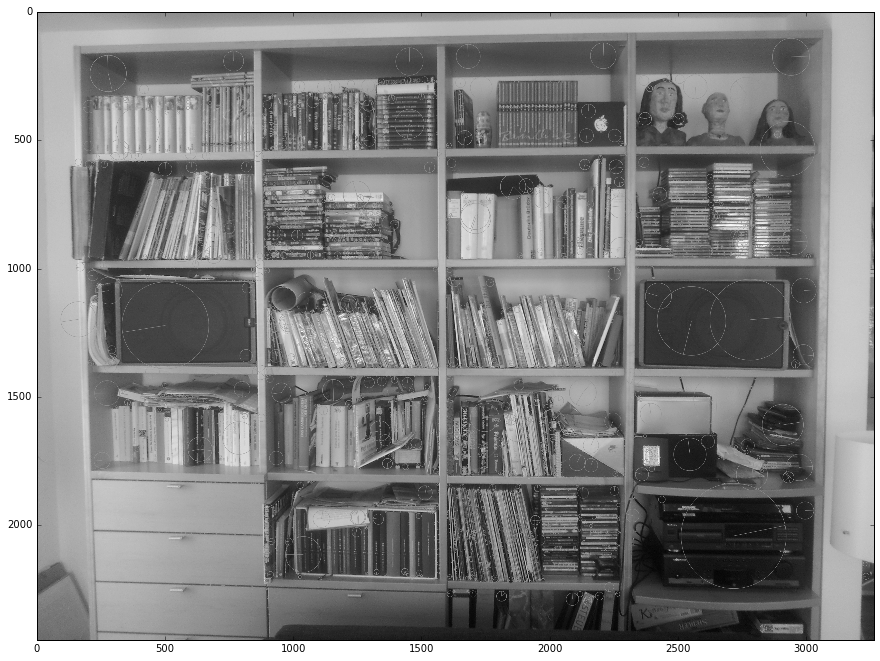

In [4]:
img2 = cv2.imread(os.path.join(img_dir, '20150616_074411.jpg'))
kp_img2, des_img2, img2_gray = compute_sift(img2, 10000)

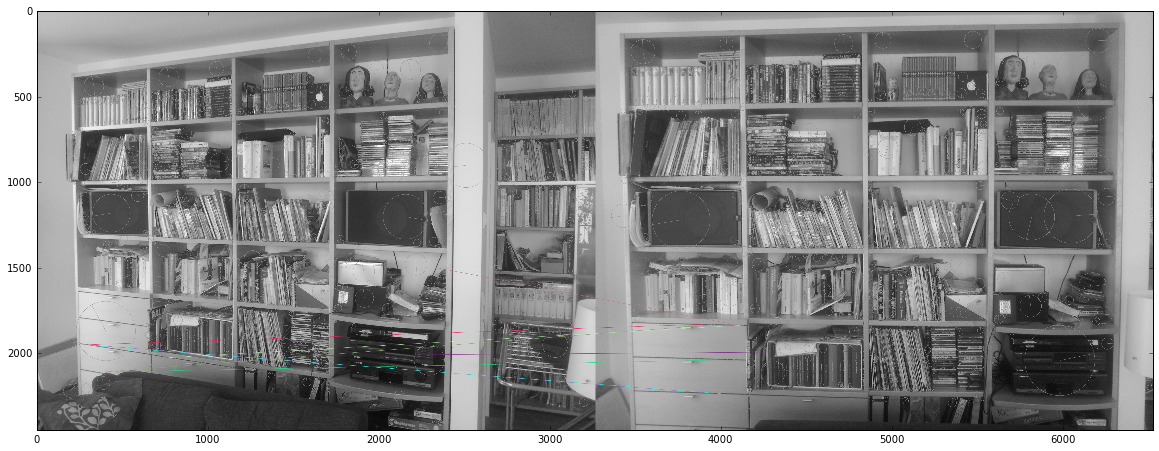

(<matplotlib.image.AxesImage at 0x7f9968835a58>, None)

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
#print(len(des_img1))

# Match descriptors.
matches = bf.match(des_img1, des_img2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv2.drawMatches(img1_gray, kp_img1, img2_gray, kp_img2, matches[:10], outImg=None, flags=2)

plt.figure(figsize=(20, 10))
plt.imshow(img3),plt.show()

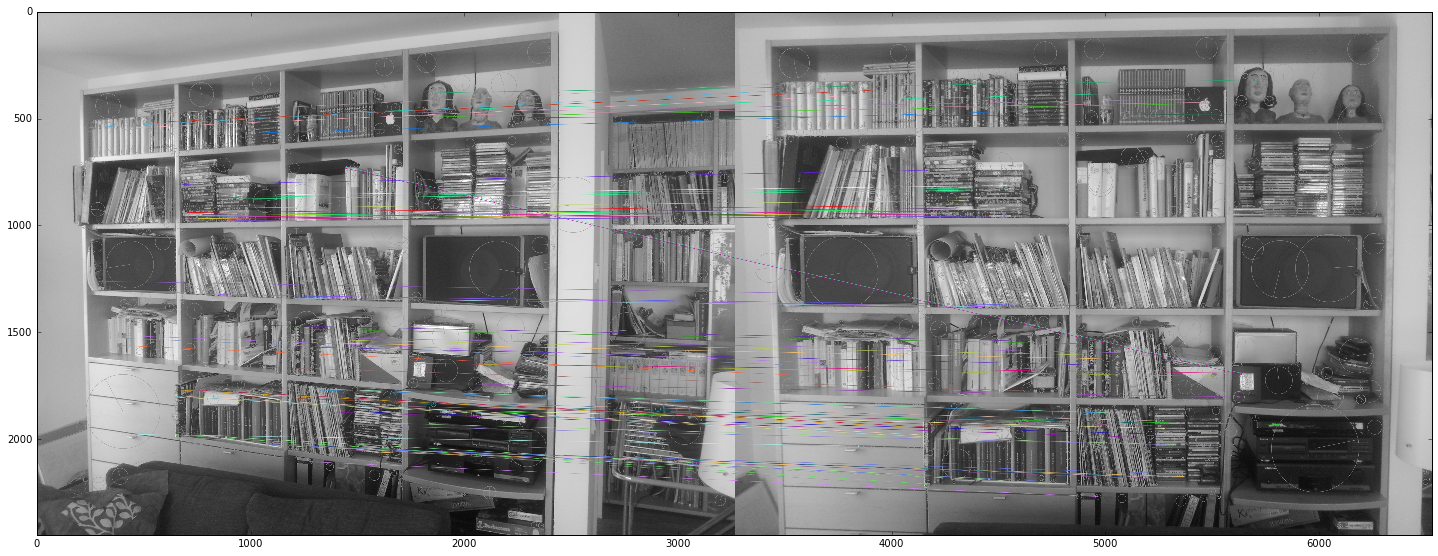

(<matplotlib.image.AxesImage at 0x7f9968655e48>, None)

In [6]:
bf = cv2.BFMatcher()
matches_knn = bf.knnMatch(des_img1, des_img2, k=2)
# Apply ratio test
good = []
pts1 = []
pts2 = []

for m,n in matches_knn:
    if m.distance < 0.50*n.distance:
        good.append([m])
        pts2.append(kp_img2[m.trainIdx].pt)
        pts1.append(kp_img1[m.queryIdx].pt)
        
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1_gray, kp_img1, img2_gray, kp_img2, good, None, flags=2)
plt.figure(figsize=(25,25))
plt.imshow(img3), plt.show()

In [7]:
correspondence_img1 = np.array(list(map(lambda x:np.array(kp_img1[x.queryIdx].pt), matches)))
correspondence_img2 = np.array(list(map(lambda x:np.array(kp_img1[x.trainIdx].pt), matches)))

#print(correspondence_img2)

In [8]:
fundamental_matrix, mask = cv2.findFundamentalMat(correspondence_img1, correspondence_img2, method=cv2.FM_8POINT)
print(fundamental_matrix)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

fundamental_matrix_knn, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_LMEDS)
print(fundamental_matrix_knn)

[[  1.27171256e-08  -9.81745360e-08   1.10728077e-04]
 [ -5.20291441e-08   6.83598906e-07  -8.57118352e-04]
 [  5.27268448e-05  -7.84435130e-04   1.00000000e+00]]
[[ -1.11180228e-08  -6.07259089e-08  -1.13677620e-05]
 [  4.25636469e-07   1.88125916e-08   2.39800849e-03]
 [ -3.28058830e-04  -3.36074750e-03   1.00000000e+00]]


basic matching is wrong somehow


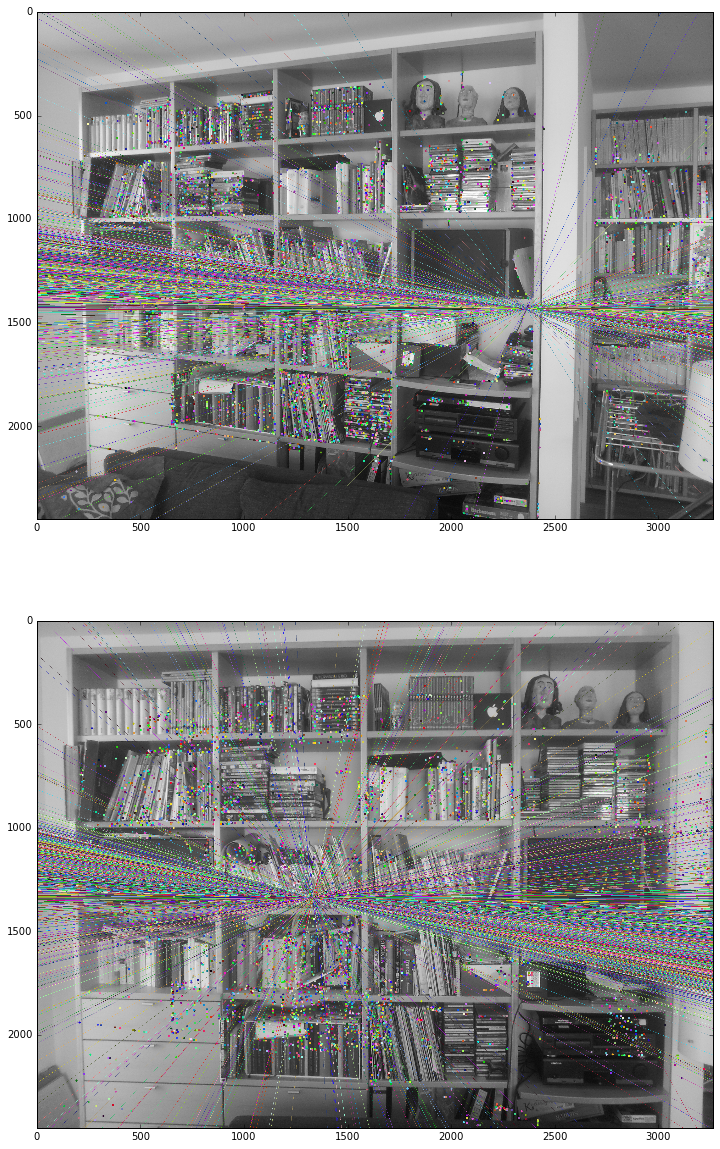

In [9]:
from robot_perception.src.fundamental_matrix_estimation import util

print("basic matching is wrong somehow")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

lines1, lines2 = util.draw_epilines(img1_gray, img2_gray, correspondence_img1, correspondence_img2, fundamental_matrix)

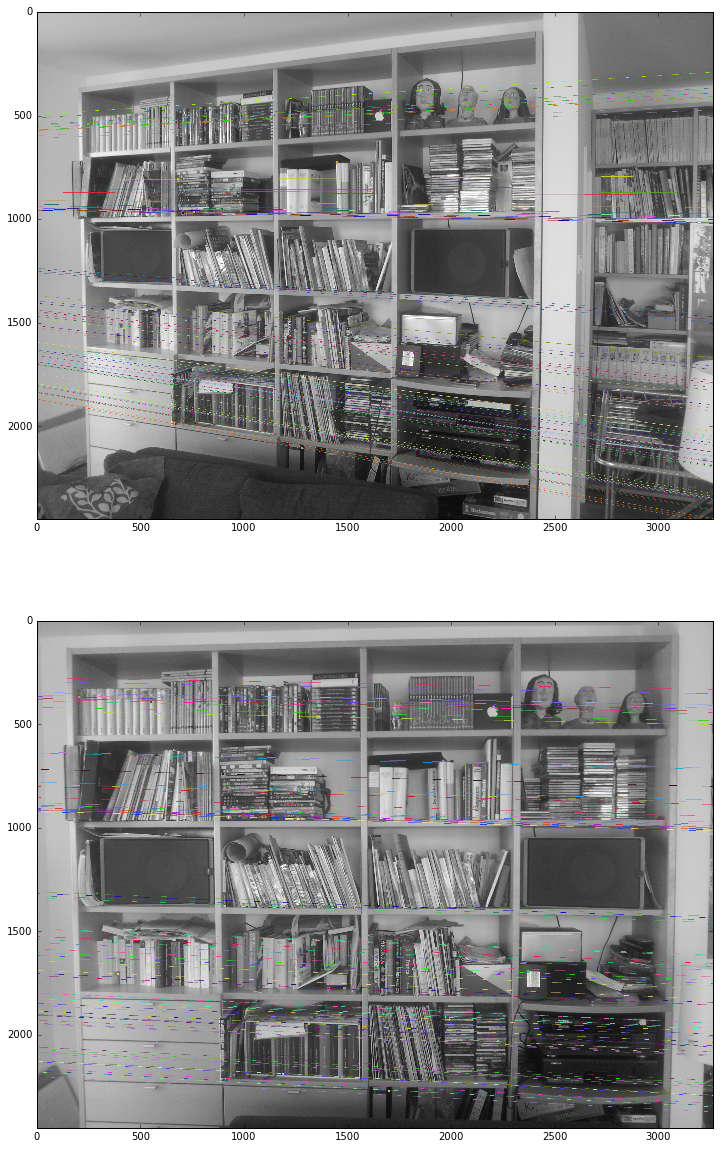

In [10]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

lines1, lines2 = util.draw_epilines(img1_gray, img2_gray, pts1, pts2, fundamental_matrix_knn)

In [11]:
print("Epipole:")
e_h = np.cross(lines2[0,:],lines2[1,:])
epipole = (e_h/e_h[2])
print(epipole)


e_x = np.zeros((3,3))
e_x[0,1] = - epipole[2]
e_x[0,2] = + epipole[1]
e_x[1,2] = - epipole[0]

e_x[1,0] = + epipole[2]
e_x[0,2] = - epipole[1]
e_x[2,1] = + epipole[0]
print("\nConstruction of the [e]x matrix")
print(e_x)
print("\nFinding P matrix from the fundamental matrix and the epipole")
h = np.dot(e_x, fundamental_matrix_knn)
P = np.hstack((h, epipole.reshape(3, 1)))
print(P)

Epipole:
[ -5.55536670e+04  -6.80364916e+02   1.00000000e+00]

Construction of the [e]x matrix
[[  0.00000000e+00  -1.00000000e+00   6.80364916e+02]
 [  1.00000000e+00   0.00000000e+00   5.55536670e+04]
 [  0.00000000e+00  -5.55536670e+04   0.00000000e+00]]

Finding P matrix from the fundamental matrix and the epipole
[[ -2.23200144e-01  -2.28653471e+00   6.80362518e+02  -5.55536670e+04]
 [ -1.82248710e+01  -1.86701848e+02   5.55536670e+04  -6.80364916e+02]
 [ -2.36456667e-02  -1.04510845e-03  -1.33218165e+02   1.00000000e+00]]


In [12]:
# Task 3 requires calculating camera matrices from a fundamental matrix from task 1
# The algorithm may be in section 9.5.3 (Hartley and Zisserman)
cameraMatrix, rotMatrix, transVect, rotMatrixX, rotMatrixY, rotMatrixZ, eulerAngles = cv2.decomposeProjectionMatrix(P)
print("Camera matrix:")
print(cameraMatrix)
print("\nRotation matrix:")
print(rotMatrix)
print("\nTranslation vector:")
print(transVect[:3])


Camera matrix:
[[  0.00000000e+00   2.31753918e+00  -6.80362450e+02]
 [  0.00000000e+00   1.89233450e+02  -5.55536614e+04]
 [  0.00000000e+00   0.00000000e+00   1.33218167e+02]]

Rotation matrix:
[[  9.88924890e-01  -1.48416752e-01  -1.74365686e-04]
 [ -1.48416748e-01  -9.88924905e-01   3.41015561e-05]
 [ -1.77495811e-04  -7.84508953e-06  -9.99999984e-01]]

Translation vector:
[[ -9.88924890e-01]
 [  1.48416752e-01]
 [  1.74365686e-04]]


In [13]:
homograpy_3d2d = np.dot(cameraMatrix, np.append(rotMatrix[:,:2], transVect[:3], axis=1))
print("Homography 2d to 3d")
print(homograpy_3d2d)

Homography 2d to 3d
[[ -2.23200144e-01  -2.28653471e+00   2.25329772e-01]
 [ -1.82248710e+01  -1.86701848e+02   1.83987616e+01]
 [ -2.36456667e-02  -1.04510845e-03   2.32286771e-02]]


In [44]:
points = np.genfromtxt(os.path.join(img_dir, "shelf0straightwithLinesPoints.csv"), delimiter=',', usecols=(1, 2))
points = np.append(points, np.ones((len(points), 1)), axis=1)
projections = None
for point in points:
    projection = np.dot(homograpy_3d2d, point).reshape(1, 3)
    projection = projection/projection[0, 2]
    projections = np.append(projections, projection, axis=0) if projections is not None else projection

print(projections)

[[  1.02204522e+02   8.34527892e+03   1.00000000e+00]
 [  1.24811403e+01   1.01911797e+03   1.00000000e+00]
 [  1.30364753e+01   1.06446260e+03   1.00000000e+00]
 [  5.56153396e+01   4.54114400e+03   1.00000000e+00]
 [  8.33544686e+01   6.80612020e+03   1.00000000e+00]
 [  1.86542610e+02   1.52317158e+04   1.00000000e+00]
 [  6.75993157e+01   5.51966862e+03   1.00000000e+00]
 [  1.52709299e+02   1.24691329e+04   1.00000000e+00]
 [  5.38937297e+02   4.40057115e+04   1.00000000e+00]
 [  8.01610844e+02   6.54537292e+04   1.00000000e+00]
 [  5.86097658e+02   4.78564846e+04   1.00000000e+00]
 [  1.70329495e+02   1.39078704e+04   1.00000000e+00]
 [  1.25509372e+02   1.02481840e+04   1.00000000e+00]
 [  5.12330428e+01   4.18331742e+03   1.00000000e+00]]


In [48]:
from scipy.spatial import distance

distance_11_12 = distance.euclidean(projections[11, :2], projections[12, :2])
distance_5_7 = distance.euclidean(projections[5, :2], projections[7, :2])
print("Distance of 5 and 7 in cm:")
print(distance_5_7 / distance_11_12 * 125)

Distance of 5 and 7 in cm:
94.358592754
